# Simulating 2D Epileptor model

In [1]:
import os
import sys
import time
import errno
import time


import numpy as np
import scipy as scp
import scipy as scp
import matplotlib.pyplot as plt

import re
import pandas as pd
import seaborn as sns


In [2]:
from scipy.integrate import odeint

In [3]:
from scipy.optimize import fsolve
from scipy.optimize import root

In [4]:
import numpy as np
import torch

# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
import sbi.utils as utils
from sbi.inference.base import infer

In [5]:
%pylab inline
#%matplotlib notebook

Populating the interactive namespace from numpy and matplotlib


In [6]:
plt.style.use('seaborn-talk');

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'

In [7]:
cwd = os.getcwd()
cwd

'/home/meysam/sbi-master/tutorial'

In [8]:
T = 100.0
dt=0.01
ts = np.arange(0, T + dt, dt)
sigma=1e-1

In [9]:
nt=ts.shape[0]
nt

10001

In [10]:
tau0=10.
I1=3.1
eta_true=-1.5

In [11]:
x, z= np.zeros(nt), np.zeros(nt)

In [12]:
x_init, z_init=-2.5, 3.5
x[0],z[0]=x_init, z_init

In [13]:
for i in range(1, nt):
    dx =1.0 - x[i-1]**3 - 2.0*x[i-1]**2 - z[i-1] + I1   
    dz =(1.0/tau0)*(4*(x[i-1]-eta_true) - z[i-1])
    x[i]=(x[i-1] + dt * dx )
    z[i]=(z[i-1] + dt * dz)    

In [14]:
ts.shape, x.shape

((10001,), (10001,))

/home/meysam/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


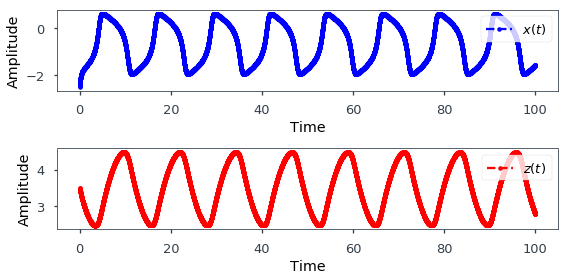

In [15]:
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.plot(ts,x , '--b.', label='$x(t)$')
plt.xlabel('Time'); plt.ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.tight_layout();
plt.subplot(212)
plt.plot(ts, z, '--r.', label='$z(t)$')
plt.xlabel('Time'); ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.tight_layout();
plt.show()

In [16]:
def dy_dt(y, ts, eta):
    I1=3.1
    tau0=10.0
    x = y[0]
    z = y[1]
    dx_dt = 1.0 - x*x*x - 2.0*x*x - z + I1;
    dz_dt = (1.0/tau0)*(4*(x - eta) - z );
    dy_dt=[dx_dt, dz_dt]
    return dy_dt

In [17]:
y_init=np.array([x_init, z_init])
y = odeint(dy_dt, y_init, ts,  args=(eta_true,))

In [18]:
y.shape

(10001, 2)

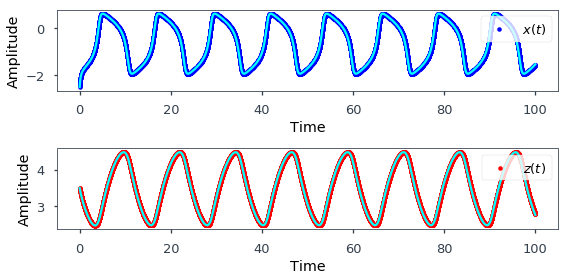

In [19]:
plt.figure(figsize=(8, 4))
plt.subplot(211)
plt.plot(ts,x , 'b.', label='$x(t)$')
plt.plot(ts,y[:,0], 'cyan')

plt.xlabel('Time'); plt.ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.tight_layout();
plt.subplot(212)
plt.plot(ts, z, 'r.', label='$z(t)$')
plt.plot(ts,y[:,1], 'cyan')
plt.xlabel('Time'); ylabel('Amplitude'); 
plt.legend(loc='upper right')
plt.tight_layout();
plt.show()

plt.show()

### Simulator

In [175]:
def Epileptor_ODEmodel(params, constants, dt, ts, seed=None):
   
    eta, x_init, z_init  = params[0], params[1], params[2]
    eta.astype(float)
    x_init.astype(float)
    z_init.astype(float)

    # fixed parameters
    tau0, I1, sigma=constants[0], constants[1], constants[2]
    dt = float(dt)

    if seed is not None:
        rng = np.random.RandomState(seed=seed)
    else:
        rng = np.random.RandomState()

   
    y_init=np.array([x_init, z_init])
    y = odeint(dy_dt, y_init, ts,  args=(eta,))
        
    return y
     

In [176]:
def Epileptor_ODEsimulator(params):


    states = Epileptor_ODEmodel(params, constants, dt, ts, seed=0)

    return states.T.reshape(-1)  

### some simulations

In [177]:
T = 100.0
dt=0.1
t = np.arange(0, T + dt, dt)
sigma=1e-1

In [178]:
# three sets of params (eta, x0, z0)
params = np.array([[-3.5, -2.5, 3.5],[-2.1, -2.5, 3.5],[-1.5, -2.5, 3.5]])
params.shape

(3, 3)

In [179]:
len(params[:,0]), ts.shape

(3, (10001,))

In [180]:
num_p = len(params[:,0])
sim_p = np.zeros((num_p, ts.shape[0]))
num_p,sim_p.shape

(3, (3, 10001))

In [183]:
for i in range(num_p):
    sim_p[i,:] = Epileptor_ODEsimulator(params=params[i,:])[0:nt]

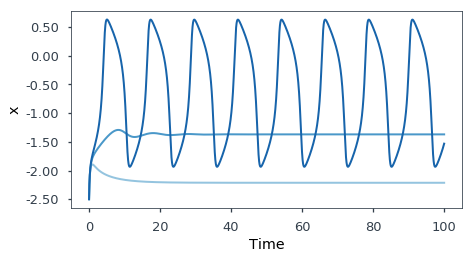

In [184]:
# colors for traces
col_min = 2
num_colors = num_p+col_min
cm1 = mpl.cm.Blues
col1 = [cm1(1.*i/num_colors) for i in range(col_min,num_colors)]


fig = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_p):
    plt.plot(ts,sim_p[i,:],color=col1[i],lw=2)

plt.xlabel('Time'); plt.ylabel('x'); 
#plt.legend(loc='upper right')
#plt.tight_layout();
#ax.set_xticks([])
#ax.set_yticks([])
#ax.set_xticks([0, max(t)/2, max(t)])
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
plt.show()

## 3. Prior over model parameters

In [98]:
prior_min = [-5., -5., 0.]
prior_max = [0., 0., 5.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

### Inference

In [99]:
start_time = time.time()

posterior = infer(Epileptor_ODEsimulator, prior, method='SNPE', num_simulations=1000, num_workers=1)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

A Jupyter Widget


Neural network successfully converged after 124 epochs.
------------------------------------------------------------
--- 1295.6131649017334 seconds ---


### Data

In [141]:
# true parameters and respective labels
true_params = np.array([-1.5, -2.5, 3.5])
labels_params = [r'$eta$', r'$x_init$', r'$z_init$']

In [142]:
ts.shape[0]

10001

In [195]:
y_obs=Epileptor_ODEsimulator(params=true_params)+sigma*randn(2*nt)

In [196]:
y_obs.shape, nt

((20002,), 10001)

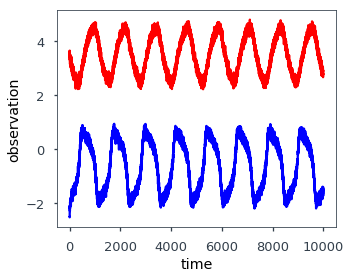

In [197]:
plt.figure(figsize=(5,4))
plt.plot(y_obs[0:nt], 'b')
plt.plot(y_obs[nt:2*nt], 'r')
plt.xlabel('time')
plt.ylabel('observation')
plt.show()

### Posterior

In [123]:
num_samples=1000

In [124]:
posterior_sample = posterior.sample((num_samples,), y_obs).numpy()

A Jupyter Widget

In [125]:
posterior_sample.shape

(1000, 3)

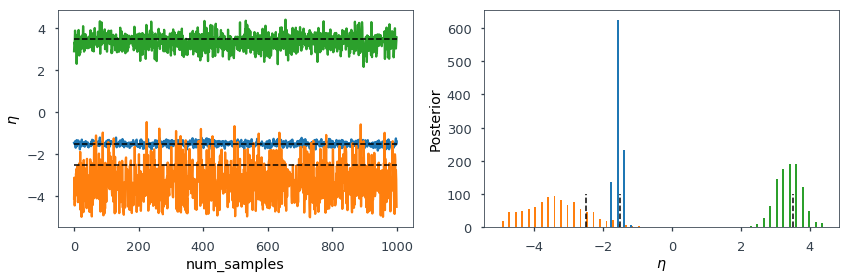

In [126]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(posterior_sample)
plt.hlines(y=true_params, xmin=0., xmax=num_samples, linewidth=1.5, color = 'k', linestyle='--', zorder=5)
plt.xlabel('num_samples')
plt.ylabel(r'$\eta$')
plt.subplot(122)
plt.hist(posterior_sample, bins=50)
plt.vlines(x=true_params, ymin=0., ymax=100, linewidth=1.5, color = 'k', linestyle='--', zorder=5)
plt.xlabel(r'$\eta$')
plt.ylabel('Posterior')
plt.show()

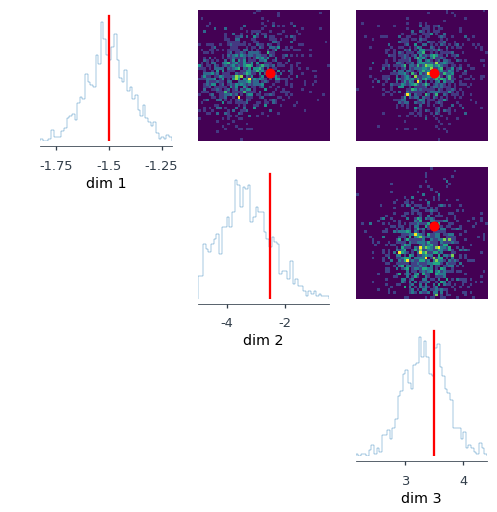

In [127]:
fig, axes = utils.pairplot(posterior_sample,
                           fig_size=(8,8),
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');

In [128]:
y_fit = Epileptor_ODEsimulator(np.percentile(posterior_sample, [50], axis=0).reshape(-1))
y_ppc_lo = Epileptor_ODEsimulator(np.percentile(posterior_sample, [5], axis=0).reshape(-1))
y_ppc_hi = Epileptor_ODEsimulator(np.percentile(posterior_sample, [95], axis=0).reshape(-1))

In [129]:
y_fit.shape

(20002,)

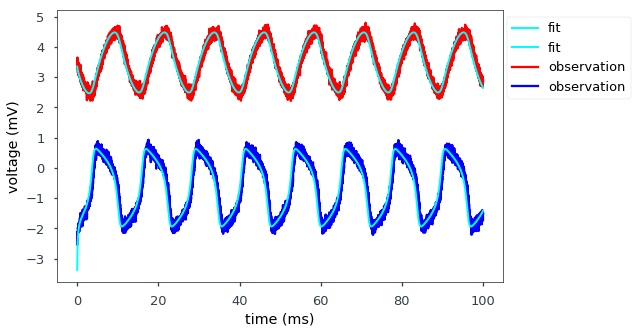

In [202]:
fig = plt.figure(figsize=(8,5))

# plot observation
#plt.plot(ts, y_obs, lw=2, color='b' , label='observation')
plt.plot(ts, y_obs[0:nt], 'b',label='observation')
plt.plot(ts,y_obs[nt:2*nt], 'r',label='observation')

# simulate and plot samples
plt.plot(ts, y_fit[0:nt], lw=2, color='cyan', label='fit')
plt.plot(ts, y_fit[nt:2*nt], lw=2, color='cyan', label='fit')


#plt.fill_between(t, y_ppc_lo, y_ppc_hi, color='green', alpha=.6) 
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), 
          loc='upper right')

plt.show()
# ax.set_xticks([0, 60, 120])
# ax.set_yticks([-80, -20, 40]);

In [203]:
### Wider prior

In [204]:
prior_min = [-50., -50., -50.]
prior_max = [50., 50., 50.]
prior = utils.torchutils.BoxUniform(low=torch.as_tensor(prior_min), high=torch.as_tensor(prior_max))

### Inference

In [205]:
start_time = time.time()

posterior = infer(Epileptor_ODEsimulator, prior, method='SNPE', num_simulations=1000, num_workers=1)

print ("-"*60)
print("--- %s seconds ---" % (time.time() - start_time))

A Jupyter Widget


Neural network successfully converged after 56 epochs.
------------------------------------------------------------
--- 560.505562543869 seconds ---


### Data

In [206]:
# true parameters and respective labels
true_params = np.array([-1.5, -2.5, 3.5])
labels_params = [r'$eta$', r'$x_init$', r'$z_init$']

In [207]:
ts.shape[0]

10001

In [208]:
y_obs=Epileptor_ODEsimulator(params=true_params)+sigma*randn(2*nt)

In [209]:
y_obs.shape, nt

((20002,), 10001)

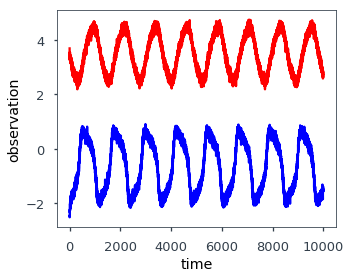

In [210]:
plt.figure(figsize=(5,4))
plt.plot(y_obs[0:nt], 'b')
plt.plot(y_obs[nt:2*nt], 'r')
plt.xlabel('time')
plt.ylabel('observation')
plt.show()

### Posterior

In [211]:
num_samples=1000

In [212]:
posterior_sample = posterior.sample((num_samples,), y_obs).numpy()

A Jupyter Widget

In [213]:
posterior_sample.shape

(1000, 3)

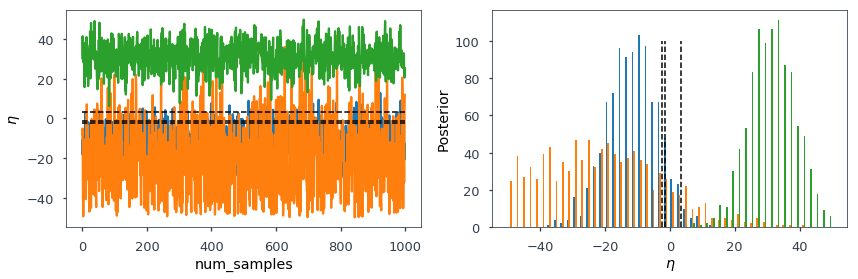

In [214]:
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(posterior_sample)
plt.hlines(y=true_params, xmin=0., xmax=num_samples, linewidth=1.5, color = 'k', linestyle='--', zorder=5)
plt.xlabel('num_samples')
plt.ylabel(r'$\eta$')
plt.subplot(122)
plt.hist(posterior_sample, bins=50)
plt.vlines(x=true_params, ymin=0., ymax=100, linewidth=1.5, color = 'k', linestyle='--', zorder=5)
plt.xlabel(r'$\eta$')
plt.ylabel('Posterior')
plt.show()

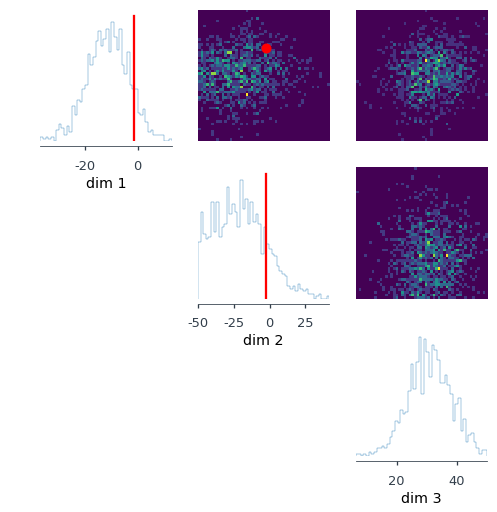

In [215]:
fig, axes = utils.pairplot(posterior_sample,
                           fig_size=(8,8),
                           points=true_params,
                           points_offdiag={'markersize': 20},
                           points_colors='r');

In [216]:
y_fit = Epileptor_ODEsimulator(np.percentile(posterior_sample, [50], axis=0).reshape(-1))
y_ppc_lo = Epileptor_ODEsimulator(np.percentile(posterior_sample, [5], axis=0).reshape(-1))
y_ppc_hi = Epileptor_ODEsimulator(np.percentile(posterior_sample, [95], axis=0).reshape(-1))

In [217]:
y_fit.shape

(20002,)

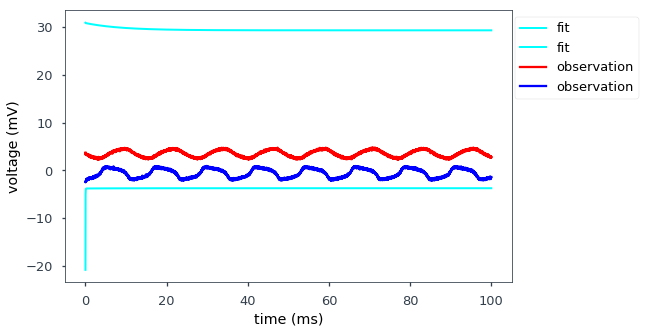

In [218]:
fig = plt.figure(figsize=(8,5))

# plot observation
#plt.plot(ts, y_obs, lw=2, color='b' , label='observation')
plt.plot(ts, y_obs[0:nt], 'b',label='observation')
plt.plot(ts,y_obs[nt:2*nt], 'r',label='observation')

# simulate and plot samples
plt.plot(ts, y_fit[0:nt], lw=2, color='cyan', label='fit')
plt.plot(ts, y_fit[nt:2*nt], lw=2, color='cyan', label='fit')


#plt.fill_between(t, y_ppc_lo, y_ppc_hi, color='green', alpha=.6) 
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.3, 1), 
          loc='upper right')

plt.show()
# ax.set_xticks([0, 60, 120])
# ax.set_yticks([-80, -20, 40]);